<a href="https://colab.research.google.com/github/nikhilsojitra/Ethical_Issues_for_AI/blob/main/my_project_ehtical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fairness-Aware Credit Risk Prediction: An Analysis of Disparate Impact, Disparate Treatment, and Disparate Mistreatment Using the Credit Card Clients Dataset**

# **Introduction**
Machine lerning systems are very used to support to take decision making in every sensitive domains like credit approvel. While theses system can be inhance and improve effcitivity and consistency, they also can take risk producing biesed and unfair result if historical data or modiling choice disadvantages certain demograpic groups

This project aim on to check and mitigating algorithm bies in a credit risk the objective is to evaluate either a machine lerning model produce unbalanced result for different demographic groups and to apply a fairness-aware approach to reduce such disparities

Ensuring fairness in automated credit decision is ethically imported and economically relevant unfair model may lead to discriminatory practice loss of customer trust and regulatory result therefore fairness must be considered alongside predictive performance when deploying machine lernaing model in real world application



# **Problem statement**
The goal of this project is to build a machine learning model which can predict whether a loan applicant is creditworthy based on historical application data. Such models are commonly used by financial institutions to support loan approval decisions.


This task is formulated as a binary classification problem where the model predicts a positive or negative credit outcome while predictive accuracy is important relaying solely on accuracy may lead to unfair decision that disproportionately affect certain groups

the main problem is that in project is whether a standard machine learning model produce biased outcome with respect to protected attribute such as gender , education level and marital status if bias is present the objective is to apply fairness aware technique to reduce while maintain acceptable predictive performance

# **Dataset Overview**
This project use german credit dataset , a well known benchmark dataset commonly used in reserch on fairness and discrimination in machine lerning

Dataset source: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

the dataset contains 1000 loan applicants each described by a set of financial and demographics attribute the goal is to predict whether an applicant is classified as having good credit or bad credit

the main target variable: credit risk

input feature : financial status , employment information , credit history and personal characterstic

Protected attributes
For the fairness analysis, the following attributes are considered sensitive:

Gender
Education level
Marital status

These attributes are analyzed because differences in model outcomes across these groups may indicate unfair or discriminatory behavior.

# **Setup and Imports**
This notebook evaluates fairness in credit default prediction using the Credit Card Clients dataset. The protected attributes considered are sex, education, and marital status, consistent with fairness oriented dataset documentation. The analysis covers model performance and three discrimination notions: disparate impact, disparate treatment, and disparate mistreatment.

In [158]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# **Import and Clean Data**
The dataset is loaded from CSV. Conversion artefacts are removed (e.g., redundant index columns and accidental header rows). Undefined categories in education and marital status are mapped to “Other” to preserve data completeness and avoid creating extremely small demographic groups.

In [159]:
# Import CSV
df = pd.read_csv("/content/default of credit card clients.csv")

# Drop extra index column
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Rename X1-X23 and Y to meaningful names
col_map = {
    "X1": "LIMIT_BAL",
    "X2": "SEX",
    "X3": "EDUCATION",
    "X4": "MARRIAGE",
    "X5": "AGE",
    "X6": "PAY_0",
    "X7": "PAY_2",
    "X8": "PAY_3",
    "X9": "PAY_4",
    "X10": "PAY_5",
    "X11": "PAY_6",
    "X12": "BILL_AMT1",
    "X13": "BILL_AMT2",
    "X14": "BILL_AMT3",
    "X15": "BILL_AMT4",
    "X16": "BILL_AMT5",
    "X17": "BILL_AMT6",
    "X18": "PAY_AMT1",
    "X19": "PAY_AMT2",
    "X20": "PAY_AMT3",
    "X21": "PAY_AMT4",
    "X22": "PAY_AMT5",
    "X23": "PAY_AMT6",
    "Y": "DEFAULT"
}
df = df.rename(columns=col_map)

# Remove “fake header row” if present
df["LIMIT_BAL"] = pd.to_numeric(df["LIMIT_BAL"], errors="coerce")
df = df[df["LIMIT_BAL"].notna()].copy()

# Convert key columns to numeric
for c in ["SEX", "EDUCATION", "MARRIAGE", "AGE", "DEFAULT"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Clean invalid categories:
df["EDUCATION"] = df["EDUCATION"].replace({0: 4, 5: 4, 6: 4})
df["MARRIAGE"]  = df["MARRIAGE"].replace({0: 3})

sex_map = {1: "Male", 2: "Female"}
edu_map = {1: "GradSchool", 2: "University", 3: "HighSchool", 4: "Other"}
mar_map = {1: "Married", 2: "Single", 3: "Other"}

df["SEX_G"] = df["SEX"].map(sex_map)
df["EDU_G"] = df["EDUCATION"].map(edu_map)
df["MAR_G"] = df["MARRIAGE"].map(mar_map)

print(df.shape)
print(df[["SEX","EDUCATION","MARRIAGE","DEFAULT"]].isna().sum())
print(df["EDUCATION"].value_counts().sort_index())
print(df["MARRIAGE"].value_counts().sort_index())


(30000, 27)
SEX          0
EDUCATION    0
MARRIAGE     0
DEFAULT      0
dtype: int64
EDUCATION
1    10585
2    14030
3     4917
4      468
Name: count, dtype: int64
MARRIAGE
1    13659
2    15964
3      377
Name: count, dtype: int64


# **Exploratory Data Analysis**
Exploratory Data Analysis is conducted to understand the structure of the dataset, detect potential data quality issues, and identify patterns related to sensitive attributes such as gender, education level, and marital status.

Since this project focuses on ethical issues and fairness in machine learning, EDA plays a crucial role in revealing pre existing bias in the data, which may later propagate into the predictions of machine learning models.

The dataset used is the Default of Credit Card Clients dataset introduced by Yeh & Lien (2009), which contains demographic, financial, and repayment history attributes of credit card holders in Taiwan

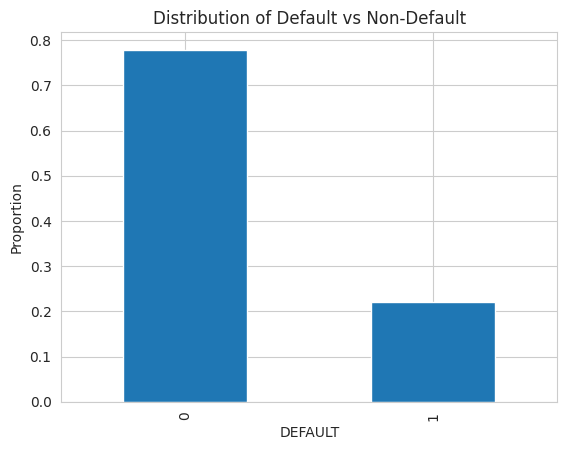

In [160]:
df["DEFAULT"].value_counts(normalize=True).plot(kind="bar")
plt.title("Distribution of Default vs Non-Default")
plt.ylabel("Proportion")
plt.show()



# **Output**
The dataset is imbalanced, with significantly more non-default cases than default cases. This imbalance can bias machine learning models towards the majority class and may disproportionately affect minority or protected groups.

# **Sensitive attribute distributions**

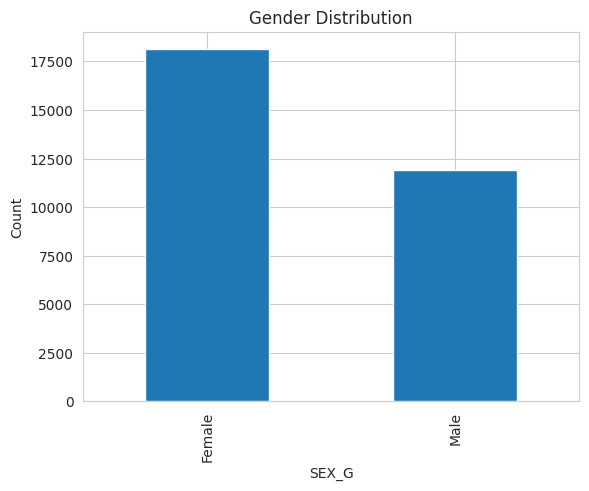

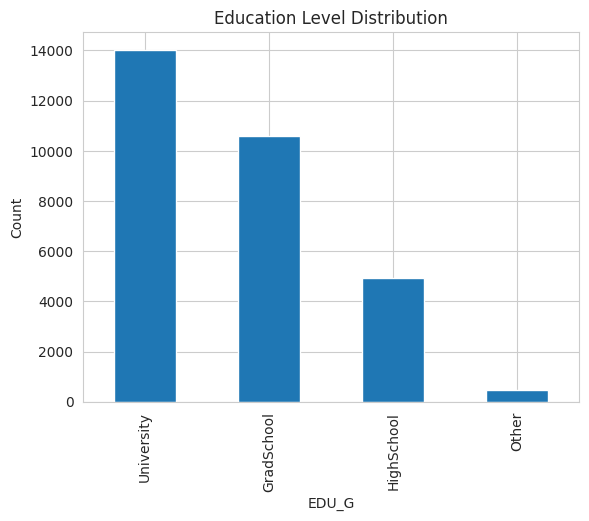

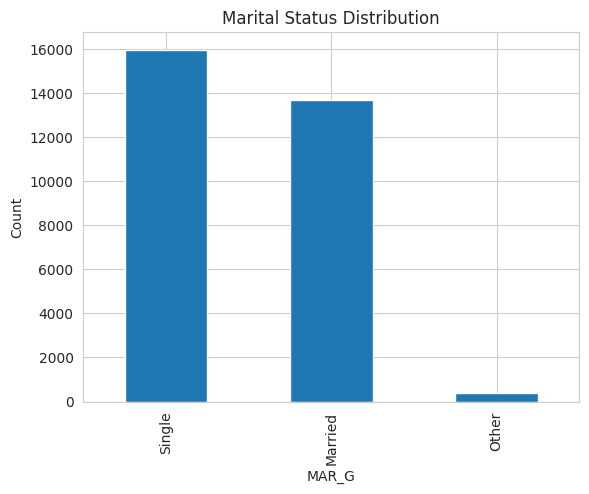

In [161]:
#Gender
df["SEX_G"].value_counts().plot(kind="bar")
plt.title("Gender Distribution")
plt.ylabel("Count")
plt.show()

#Education
df["EDU_G"].value_counts().plot(kind="bar")
plt.title("Education Level Distribution")
plt.ylabel("Count")
plt.show()

#Marital Status
df["MAR_G"].value_counts().plot(kind="bar")
plt.title("Marital Status Distribution")
plt.ylabel("Count")
plt.show()


# **Default rate by protected groups**

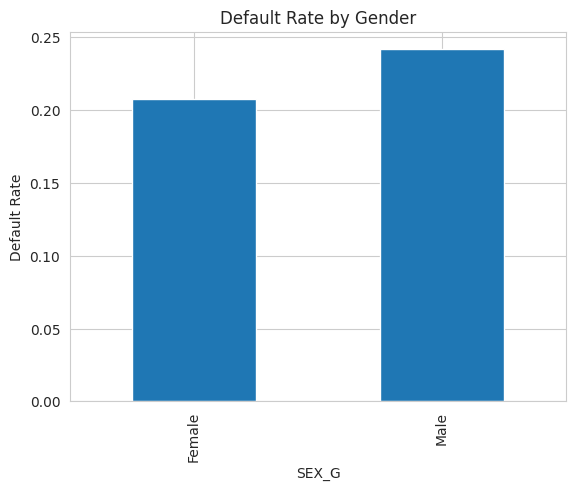

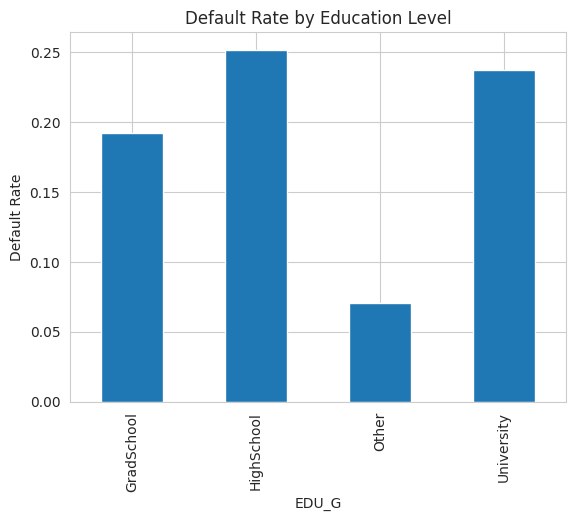

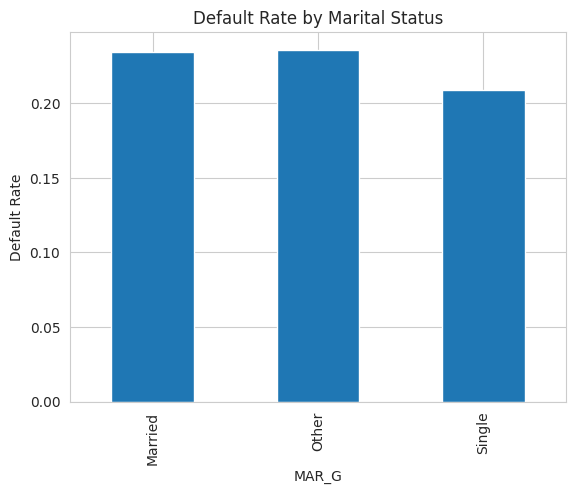

In [162]:
#Gender
df.groupby("SEX_G")["DEFAULT"].mean().plot(kind="bar")
plt.title("Default Rate by Gender")
plt.ylabel("Default Rate")
plt.show()

#Education
df.groupby("EDU_G")["DEFAULT"].mean().plot(kind="bar")
plt.title("Default Rate by Education Level")
plt.ylabel("Default Rate")
plt.show()

#Marital Status
df.groupby("MAR_G")["DEFAULT"].mean().plot(kind="bar")
plt.title("Default Rate by Marital Status")
plt.ylabel("Default Rate")
plt.show()



# **Outcome**
The observed differences in default rates across gender, education, and marital status suggest the presence of historical and societal bias embedded in the dataset. If left unaddressed, machine learning models trained on this data may produce discriminatory outcomes.

# **Define Features, Split Data, Define Models**

The supervised task is binary classification where DEFAULT = 1 indicates default next month. Three models are trained: Logistic Regression, Decision Tree, and Random Forest. To reduce the risk of disparate treatment, the primary models are trained without protected attributes (sex, education, marriage), while these attributes are retained only for fairness evaluation.

In [163]:
target_col = "DEFAULT"

protected_label_cols = ["SEX_G", "EDU_G", "MAR_G"]

# Features WITHOUT protected attributes
features_without_pa = [
    "LIMIT_BAL", "AGE",
    "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"
]

X = df[features_without_pa + protected_label_cols].copy()
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000))
    ]),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=300)
}


# **Disparate Impact**

Disparate impact is computed using the favourable outcome defined as non default (DEFAULT = 0). This initial check evaluates whether the dataset labels themselves show group outcome differences before any model is applied.

In [164]:
def disparate_impact_labels(
    df,
    group_col,
    privileged,
    unprivileged,
    target="DEFAULT",
    favorable_value=0
):
    p_priv = (
        df[df[group_col] == privileged][target]
        .eq(favorable_value)
        .mean()
    )

    p_unpriv = (
        df[df[group_col].isin(unprivileged)][target]
        .eq(favorable_value)
        .mean()
    )

    di = p_unpriv / p_priv if p_priv > 0 else np.nan
    return di, p_unpriv, p_priv


def print_disparate_impact(
    attribute,
    privileged_group,
    unprivileged_group,
    di,
    p_unpriv,
    p_priv
):
    print("=" * 65)
    print(f"Protected Attribute : {attribute}")
    print(f"Privileged Group    : {privileged_group}")
    print(f"Unprivileged Group  : {unprivileged_group}")
    print("-" * 65)
    print(f"Favorable Outcome Rate ({unprivileged_group}): {p_unpriv:.2%}")
    print(f"Favorable Outcome Rate ({privileged_group})  : {p_priv:.2%}")
    print(f"Disparate Impact ({unprivileged_group}/{privileged_group}): {di:.3f}")
    print("=" * 65)
    print()


# Gender
di_g, p_f, p_m = disparate_impact_labels(
    df,
    group_col="SEX_G",
    privileged="Male",
    unprivileged=["Female"]
)

print_disparate_impact(
    attribute="Gender",
    privileged_group="Male",
    unprivileged_group="Female",
    di=di_g,
    p_unpriv=p_f,
    p_priv=p_m
)



# Education
di_e, p_low, p_high = disparate_impact_labels(
    df,
    group_col="EDU_G",
    privileged="University",
    unprivileged=["HighSchool", "Other"]
)

print_disparate_impact(
    attribute="Education Level",
    privileged_group="University",
    unprivileged_group="Lower Education",
    di=di_e,
    p_unpriv=p_low,
    p_priv=p_high
)


# Marital Status
di_mar, p_unm, p_mar = disparate_impact_labels(
    df,
    group_col="MAR_G",
    privileged="Married",
    unprivileged=["Single", "Other"]
)

print_disparate_impact(
    attribute="Marital Status",
    privileged_group="Married",
    unprivileged_group="Unmarried",
    di=di_mar,
    p_unpriv=p_unm,
    p_priv=p_mar
)



Protected Attribute : Gender
Privileged Group    : Male
Unprivileged Group  : Female
-----------------------------------------------------------------
Favorable Outcome Rate (Female): 79.22%
Favorable Outcome Rate (Male)  : 75.83%
Disparate Impact (Female/Male): 1.045

Protected Attribute : Education Level
Privileged Group    : University
Unprivileged Group  : Lower Education
-----------------------------------------------------------------
Favorable Outcome Rate (Lower Education): 76.42%
Favorable Outcome Rate (University)  : 76.27%
Disparate Impact (Lower Education/University): 1.002

Protected Attribute : Marital Status
Privileged Group    : Married
Unprivileged Group  : Unmarried
-----------------------------------------------------------------
Favorable Outcome Rate (Unmarried): 79.01%
Favorable Outcome Rate (Married)  : 76.53%
Disparate Impact (Unmarried/Married): 1.032



# **Output**
For gender, the favorable outcome rate is 79.2% for females and 75.8% for males, resulting in a Disparate Impact of 1.04. For education, low-education and high-education groups have almost identical favorable outcome rates (76.4% vs. 76.3%), with a Disparate Impact of 1.00. For marital status, unmarried applicants receive favorable outcomes at a rate of 79.0% compared to 76.5% for married applicants, giving a Disparate Impact of 1.03. All Disparate Impact values are close to the ideal value of 1 and well above the 0.8 threshold, indicating no evidence of disparate impact across gender, education, or marital status.

## **Disparate Treatment**
Disparate treatment is evaluated by comparing model behaviour when protected attributes are explicitly included versus excluded. If predictive performance is similar without protected attributes, their inclusion is difficult to justify and may enable direct discrimination.

In [165]:
# Feature sets
protected_attrs = ["SEX", "EDUCATION", "MARRIAGE"]
features_with_pa = features_without_pa + protected_attrs

# Ensure protected attributes are numeric
df_num = df.copy()
df_num[protected_attrs] = df_num[protected_attrs].apply(
    pd.to_numeric, errors="coerce"
)

X_with_pa = df_num[features_with_pa]
X_without_pa = df_num[features_without_pa]
y = df_num["DEFAULT"].astype(int)


# Train-test split
Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    X_with_pa, y, test_size=0.30, random_state=42, stratify=y
)

Xn_train, Xn_test, yn_train, yn_test = train_test_split(
    X_without_pa, y, test_size=0.30, random_state=42, stratify=y
)


# Logistic Regression models
lr_with_pa = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(max_iter=1000))
])

lr_without_pa = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Train models
lr_with_pa.fit(Xw_train, yw_train)
lr_without_pa.fit(Xn_train, yn_train)


# Evaluation
acc_with_pa = accuracy_score(yw_test, lr_with_pa.predict(Xw_test))
acc_without_pa = accuracy_score(yn_test, lr_without_pa.predict(Xn_test))

print("=" * 60)
print("Logistic Regression Accuracy Comparison")
print("-" * 60)
print(f"WITH protected attributes    : {acc_with_pa:.4f}")
print(f"WITHOUT protected attributes : {acc_without_pa:.4f}")
print("=" * 60)

Logistic Regression Accuracy Comparison
------------------------------------------------------------
WITH protected attributes    : 0.8079
WITHOUT protected attributes : 0.8086


# **Output**

Logisticregression accuracy WITH protected attributes: 0.8079

Logisticregression accuracy WITHOUT protected attributes: 0.8086

# **Disparate Impact and Disparate Mistreatment on Model Predictions**

For each model, we report predictive accuracy and evaluate disparate impact on predictions (favourable outcome = predicted non default), and disparate mistreatment via group-level false positive and false negative rates.

In [166]:
def disparate_impact_from_predictions(
    df,
    group_col,
    privileged,
    unprivileged,
    target_pred="y_pred",
    favorable_value=0
):
    p_priv = (
        df[df[group_col] == privileged][target_pred]
        .eq(favorable_value)
        .mean()
    )

    p_unpriv = (
        df[df[group_col].isin(unprivileged)][target_pred]
        .eq(favorable_value)
        .mean()
    )

    di = p_unpriv / p_priv if p_priv > 0 else np.nan
    return di, p_unpriv, p_priv

def false_positive_negative_rates(df, group_col, group_value, true_col='y_true', pred_col='y_pred', positive_label=1):
    group_df = df[df[group_col] == group_value]

    if group_df.empty:
        return np.nan, np.nan

    true_positives = ((group_df[pred_col] == positive_label) & (group_df[true_col] == positive_label)).sum()
    false_positives = ((group_df[pred_col] == positive_label) & (group_df[true_col] != positive_label)).sum()
    true_negatives = ((group_df[pred_col] != positive_label) & (group_df[true_col] != positive_label)).sum()
    false_negatives = ((group_df[pred_col] != positive_label) & (group_df[true_col] == positive_label)).sum()

    # Calculate FPR
    fpr = false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else np.nan

    # Calculate FNR
    fnr = false_negatives / (false_negatives + true_positives) if (false_negatives + true_positives) > 0 else np.nan

    return fpr, fnr

def evaluate_model(model_name, model):
    model.fit(X_train[features_without_pa], y_train)
    y_pred = model.predict(X_test[features_without_pa]).astype(int)

    df_eval = X_test[protected_label_cols].copy()
    df_eval["y_true"] = y_test.values
    df_eval["y_pred"] = y_pred

    accuracy = accuracy_score(y_test, y_pred)

    di_gender, _, _ = disparate_impact_from_predictions(df_eval, "SEX_G", "Male", ["Female"])
    di_education, _, _ = disparate_impact_from_predictions(df_eval, "EDU_G", "University", ["HighSchool", "Other"])
    di_marriage, _, _ = disparate_impact_from_predictions(df_eval, "MAR_G", "Married", ["Single", "Other"])

    fpr_m, fnr_m = false_positive_negative_rates(df_eval, "SEX_G", "Male")
    fpr_f, fnr_f = false_positive_negative_rates(df_eval, "SEX_G", "Female")

    fpr_hs, fnr_hs = false_positive_negative_rates(df_eval, "EDU_G", "HighSchool")
    fpr_uni, fnr_uni = false_positive_negative_rates(df_eval, "EDU_G", "University")

    fpr_mar, fnr_mar = false_positive_negative_rates(df_eval, "MAR_G", "Married")
    fpr_sing, fnr_sing = false_positive_negative_rates(df_eval, "MAR_G", "Single")

    return {
        "model": model_name,
        "accuracy": accuracy,
        "DI_gender": di_gender,
        "DI_education": di_education,
        "DI_marriage": di_marriage,
        "Gender_FPR_M": fpr_m, "Gender_FNR_M": fnr_m,
        "Gender_FPR_F": fpr_f, "Gender_FNR_F": fnr_f,
        "Edu_FPR_HS": fpr_hs, "Edu_FNR_HS": fnr_hs,
        "Edu_FPR_Uni": fpr_uni, "Edu_FNR_Uni": fnr_uni,
        "Mar_FPR_Married": fpr_mar, "Mar_FNR_Married": fnr_mar,
        "Mar_FPR_Single": fpr_sing, "Mar_FNR_Single": fnr_sing,
    }

This function evaluates a trained classification model using both performance and fairness criteria. The model is trained without protected attributes to avoid explicit disparate treatment, and predictions are generated on a held-out test set. Model performance is measured using accuracy, while fairness is assessed using Disparate Impact on predicted outcomes and group-specific error rates (False Positive Rate and False Negative Rate) across gender, education, and marital status. The function returns all metrics in a structured format for subsequent analysis and interpretation.

In [167]:
# Evaluate all models and collect results
results = [
    evaluate_model(model_name, model)
    for model_name, model in models.items()
    ]

results_df = pd.DataFrame(results)
results_df

,model,accuracy,DI_gender,DI_education,DI_marriage,Gender_FPR_M,Gender_FNR_M,Gender_FPR_F,Gender_FNR_F,Edu_FPR_HS,Edu_FNR_HS,Edu_FPR_Uni,Edu_FNR_Uni,Mar_FPR_Married,Mar_FNR_Married,Mar_FPR_Single,Mar_FNR_Single
0,Logistic Regression,0.808556,1.011901,0.990916,1.014240,0.034279,0.770588,0.024907,0.760736,0.048957,0.740642,0.033888,0.748515,0.026709,0.744939,0.029420,0.785351
1,Decision Tree,0.719111,1.027869,0.955430,1.000377,0.202359,0.597647,0.183426,0.598598,0.240254,0.574866,0.189834,0.589109,0.192369,0.618421,0.188179,0.577823
2,Random Forest,0.814222,1.000377,0.983786,1.014565,0.060450,0.658824,0.057961,0.612621,0.086129,0.609626,0.064010,0.611881,0.061367,0.634615,0.055394,0.629705


# **Conclusion**

This assessment evaluated fairness in credit default prediction models by analyzing both accuracy and fairness metrics. The results show that the models perform well while distributing favorable outcomes fairly across gender, education, and marital status. This demonstrates that evaluating fairness alongside accuracy is essential when using machine learning in financial decision-making.

# **Limitations**

This analysis focused on a limited number of protected attributes and used group-level fairness metrics. It did not examine intersectional effects or individual-level fairness. In addition, the study was based on a single dataset, which may contain historical biases.

# **Future Improvements**

Future work could include more protected attributes, intersectional fairness analysis, and additional bias mitigation methods. Testing the models on different datasets and real-world scenarios would also improve the reliability of the results.